<a href="https://www.kaggle.com/code/gunrsbelti/ml-2-homework-ga22008?scriptVersionId=228912099" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Author: Gunārs Ābeltiņš, ga22008

## Library imports

In [1]:
import os
import random
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torch import nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Dataset initialization

In [2]:
class HandDataset(Dataset):
    """
    Custom dataset class for loading hand gesture images and their labels.
    """
    
    def __init__(self, data_dir, transform=transforms.Compose([
        transforms.Resize((128, 128)),  
        transforms.ToTensor()           
    ])):
        """
        Initializes the dataset.

        Args:
            data_dir (str): Path to the directory containing image files.
            transform (callable, optional): A function/transform to apply to each image.
        """
        self.data_dir = data_dir
        self.transform = transform
        self.image_files = os.listdir(data_dir)

    def __len__(self):
        """
        Returns the total number of images in the dataset.

        Returns:
            int: The number of image files in the dataset.
        """
        return len(self.image_files)

    def __getitem__(self, idx):
        """
        Returns the image and its label at the specified index.

        Args:
            idx (int): Index of the image to retrieve.

        Returns:
            tuple: (image, label) where `image` is a tensor of shape (C, H, W) and `label` is the integer class label.
        """
        img_name = self.image_files[idx]
        img_path = os.path.join(self.data_dir, img_name)
        image = Image.open(img_path).convert("RGB")

        image = self.transform(image)
        
        # Extract label from the filename (assuming format like 'label_imageName.jpg')
        label = int(img_name.split('_')[0])
        
        return image, label


train_dir = '../input/dotu-kopa-rokas/train'
test_dir = '../input/dotu-kopa-rokas/test'

train_dataset = HandDataset(train_dir)
print(f"Initialized training dataset with [{len(train_dataset)}] samples")

test_dataset = HandDataset(test_dir)
print(f"Initialized testing dataset with [{len(test_dataset)}] samples")

Initialized training dataset with [1172] samples
Initialized testing dataset with [100] samples


## Statistics about data

In [3]:
def get_labels(dataset):
    """
    Extracts the labels from the dataset based on the filenames and counts the occurrences of each label.

    Args:
        dataset (HandDataset): The dataset containing image files with labels embedded in filenames.

    Returns:
        Counter: A Counter object with labels as keys and their respective counts as values.
    """
    # Access files directly as it's faster
    labels = [int(file.split('_')[0]) for file in dataset.image_files]
    
    # Count occurrences of each label
    class_counts = Counter(labels)
    
    return class_counts

train_labels = get_labels(train_dataset)
test_labels = get_labels(test_dataset)

print("Training dataset:")
for k, v in sorted(train_labels.items()):
    print(f"Class [{k}]: [{v}] samples")

print("\nTest dataset:")
for k, v in sorted(test_labels.items()):
    print(f"Class [{k}]: [{v}] samples")

Training dataset:
Class [1]: [238] samples
Class [2]: [234] samples
Class [3]: [242] samples
Class [4]: [232] samples
Class [5]: [226] samples

Test dataset:
Class [1]: [20] samples
Class [2]: [20] samples
Class [3]: [20] samples
Class [4]: [20] samples
Class [5]: [20] samples


## Data vizualization

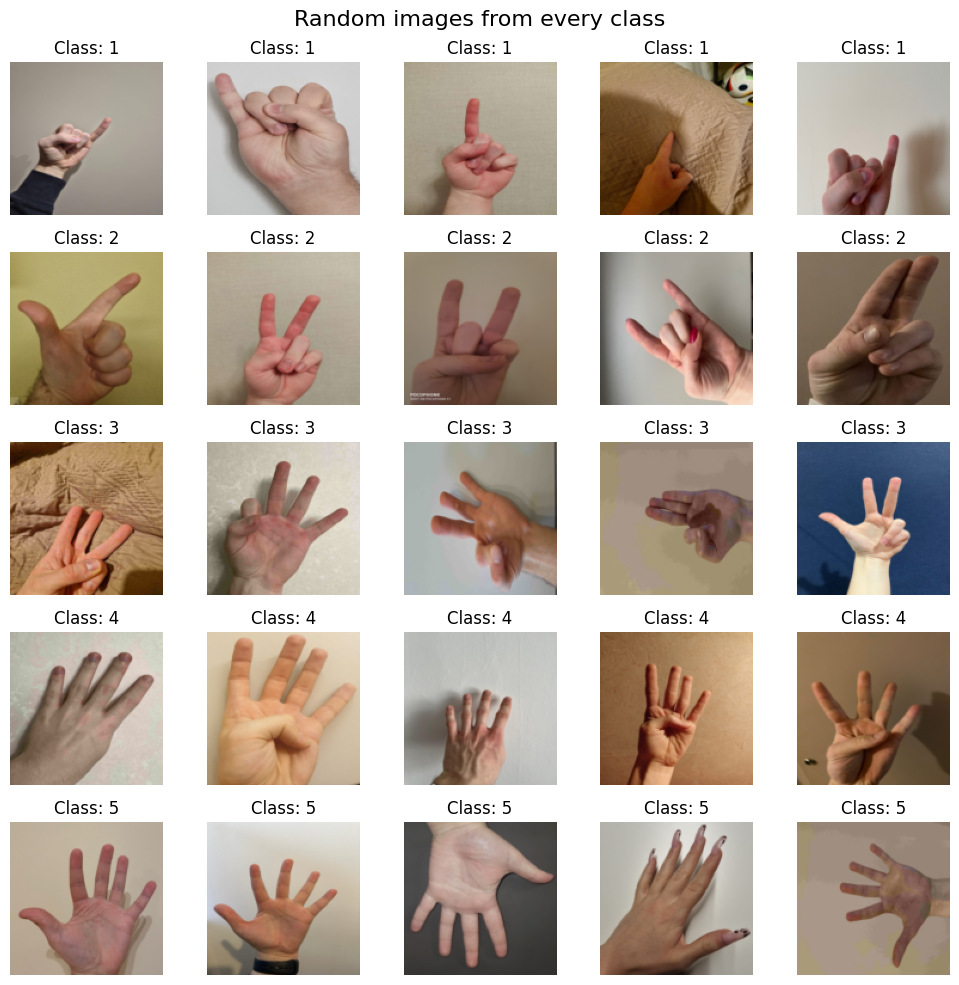

In [4]:
def show_sample_images(dataset, num_samples=5):
    """
    Displays random sample images from each class in the given dataset.

    Args:
        dataset (torch.utils.data.Dataset): The dataset containing images and labels.
        num_samples (int): The number of sample images to display per class.
    """
    loader = DataLoader(dataset, batch_size=1, shuffle=True)  # Load one image at a time
    label_to_images = {label: [] for label in range(1, 6)}  # Initialize a dictionary for labels 1 to 5

    # Collect images by class until `num_samples` per class is reached
    for image, label in loader:
        label = label.item()
        if len(label_to_images[label]) < num_samples:
            label_to_images[label].append(image.squeeze(0))
        # Break early if all classes have enough samples
        if all(len(imgs) >= num_samples for imgs in label_to_images.values()):
            break
    
    # Display the images
    fig, axes = plt.subplots(len(label_to_images), num_samples, figsize=(10, 10))
    fig.suptitle('Random images from every class', fontsize=16)

    for i, (label, images) in enumerate(sorted(label_to_images.items())):
        for j, img in enumerate(images):
            axes[i, j].imshow(img.permute(1, 2, 0))  # Convert channel-first (C, H, W) to channel-last (H, W, C)
            axes[i, j].set_title(f"Class: {label}")
            axes[i, j].axis('off')

    plt.tight_layout()
    plt.show()


show_sample_images(train_dataset)

## Placeholder model testing

In [5]:
class PlaceholderModel(nn.Module):
    """
    A placeholder neural network model that generates random probabilities 
    for a given number of output classes.
    """
    
    def __init__(self, out_features=5):
        """
        Initialize the PlaceholderModel.

        Args:
            out_features (int): Number of output classes. Default is 5.
        """
        super().__init__()
        self.out_features = out_features

    def forward(self, x):
        """
        Forward pass: Returns random probabilities for each sample in the batch.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, ...).

        Returns:
            torch.Tensor: Probabilities of shape (batch_size, out_features).
        """
        random_scores = torch.rand(x.size(0), self.out_features)
        probabilities = F.softmax(random_scores, dim=1)
        return probabilities


def test_model(ModelClass, dataset):
    """
    Test the performance of a model on a given dataset.

    Args:
        ModelClass (nn.Module): The model class to be tested.
        dataset (Dataset): The dataset to test the model on.
    """
    dataloader = DataLoader(dataset, batch_size=32, shuffle=False)
    model = ModelClass()  # Instantiate the model
    model.eval()  # Set the model to evaluation mode
    
    correct = 0
    total = 0
    
    predicted_labels = []
    true_labels = []
    
    with torch.no_grad(): 
        for images, labels in dataloader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)  # Get predicted class indices
    
            total += labels.size(0)  # Increment total sample count
            correct += (predicted == labels).sum().item()  # Count correct predictions
    
            # Store true and predicted labels for later analysis
            true_labels.extend(labels.tolist())
            predicted_labels.extend(predicted.tolist())
    
    # Compute accuracy
    accuracy = correct / total
    print(f'Precision (Test dataset): {accuracy:.2%}')

    return predicted_labels, true_labels

predicted_labels, true_labels = test_model(PlaceholderModel, test_dataset)

Precision (Test dataset): 17.00%


## Results visualization

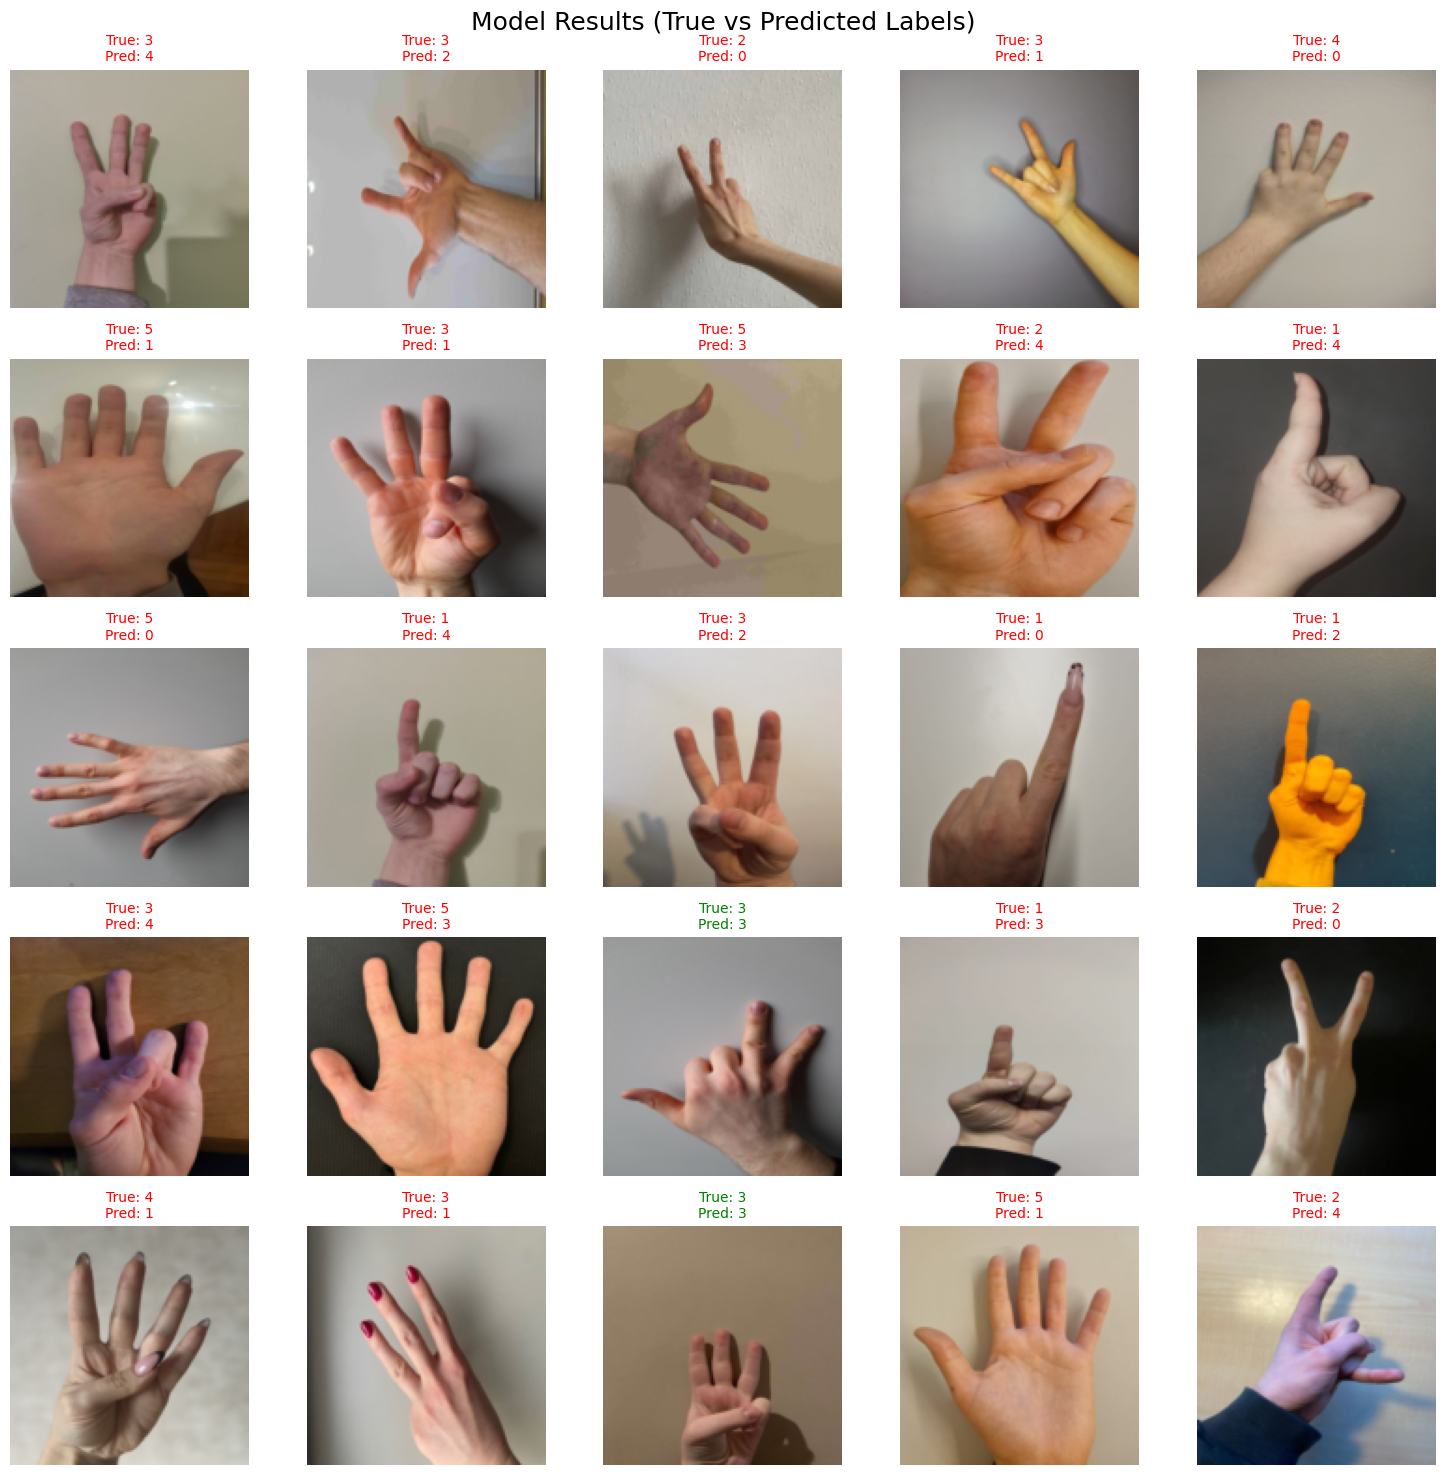

In [6]:
def show_model_results(dataset, true_labels, predicted_labels, num_rows=5, num_cols=5):
    """
    Visualizes model predictions by displaying random images from the dataset
    along with their true and predicted labels.

    Args:
        dataset (torch.utils.data.Dataset): The dataset containing the images and labels.
        true_labels (list): The ground truth labels for the dataset.
        predicted_labels (list): The predicted labels generated by the model.
        num_rows (int): Number of rows in the display grid. Default is 5.
        num_cols (int): Number of columns in the display grid. Default is 5.
    """
    num_samples = num_rows * num_cols
    indices = random.sample(range(len(dataset)), num_samples)
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))
    fig.suptitle('Model Results (True vs Predicted Labels)', fontsize=18)

    for i, idx in enumerate(indices):
        row, col = divmod(i, num_cols)
        image, label = dataset[idx]
        
        ax = axes[row][col]
        ax.imshow(image.permute(1, 2, 0))  # Convert from (C, H, W) to (H, W, C) for display
        
        color = 'green' if true_labels[idx] == predicted_labels[idx] else 'red'
        
        ax.set_title(f'True: {true_labels[idx]}\nPred: {predicted_labels[idx]}', 
                     fontsize=10, color=color)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

show_model_results(test_dataset, true_labels, predicted_labels)

## Error analysis

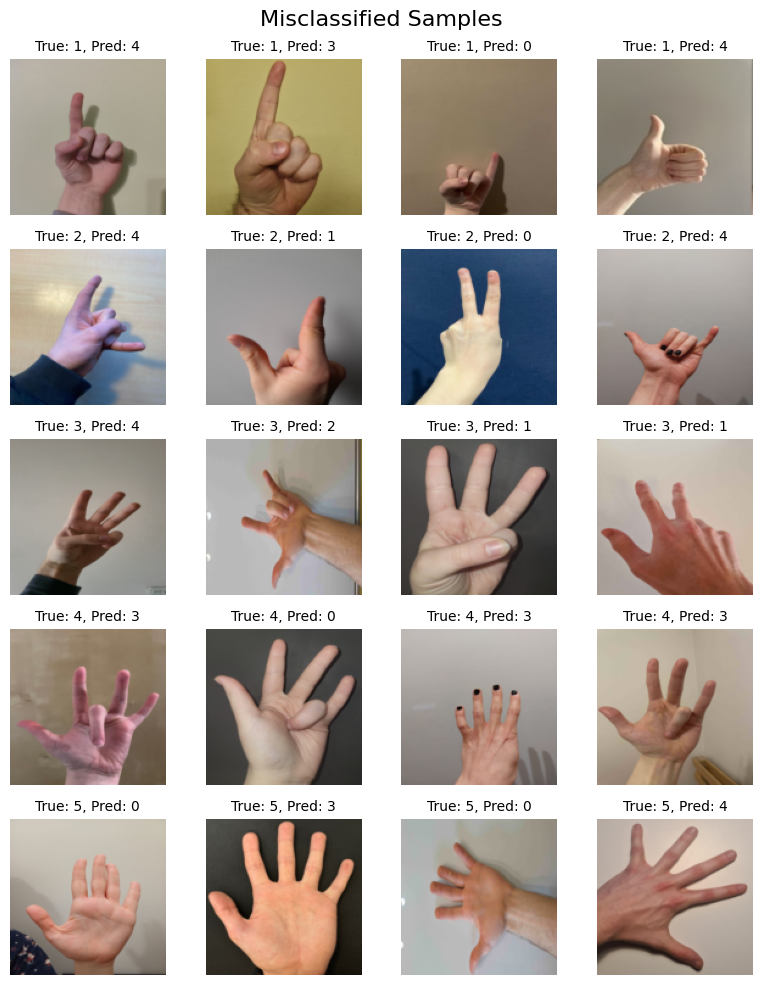

In [7]:
def show_misclassified_samples(dataset, true_labels, predicted_labels, num_samples_per_class=4):
    """
    Displays misclassified samples from the dataset, grouped by true labels.

    Args:
        dataset (torch.utils.data.Dataset): The dataset containing images and labels.
        true_labels (list): Ground truth labels for the dataset.
        predicted_labels (list): Predicted labels generated by the model.
        num_samples_per_class (int): Number of misclassified samples to display per class. Default is 2.
    """
    # Collect misclassified samples (index, true label, predicted label)
    misclassified = [(i, true, pred) for i, (true, pred) in enumerate(zip(true_labels, predicted_labels)) if true != pred]
    
    # Group misclassified samples by true label
    misclassified_by_class = {i: [] for i in range(1, 6)}
    for i, true, pred in misclassified:
        misclassified_by_class[true].append((i, pred))
    
    # Filter only classes with misclassified samples
    misclassified_by_class = {k: v for k, v in misclassified_by_class.items() if len(v) > 0}
    
    # Create a grid for visualization
    num_rows = len(misclassified_by_class)
    fig, axes = plt.subplots(num_rows, num_samples_per_class, figsize=(8, 2 * num_rows))
    fig.suptitle('Misclassified Samples', fontsize=16)

    for row, (true_label, samples) in enumerate(sorted(misclassified_by_class.items())):
        # Select up to `num_samples_per_class` samples for display
        selected_samples = random.sample(samples, min(num_samples_per_class, len(samples)))
        for col, (idx, pred) in enumerate(selected_samples):
            image, _ = dataset[idx]
            
            # Handle cases for single or multiple rows/columns
            if num_rows > 1:
                ax = axes[row][col]
            else:
                ax = axes[col] if num_samples_per_class > 1 else axes

            ax.imshow(image.permute(1, 2, 0))  # Convert (C, H, W) to (H, W, C)
            ax.set_title(f'True: {true_label}, Pred: {pred}', fontsize=10)
            ax.axis('off')

    plt.tight_layout()
    plt.show()

show_misclassified_samples(test_dataset, true_labels, predicted_labels)